# Implementing a Neural Network
---

This notebook is the implementation of the blog post at [markus.ylisiurunen.com/blog/understanding-neural-networks](https://markus.ylisiurunen.com/blog/understanding-neural-networks).

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc

rc('animation', html='html5')

%matplotlib inline

## Introduction
---

We will be implementing building blocks for the neural network. A key part of training an NN is to be able to compute gradients w.r.t. different parameters. These are then used for optimization purposes. In order for us to test our implementations, we'd like to have a robust way of getting the correct (or very close to it) gradient from any function. Luckily, we can write a small utility for doing this numerically.

In [275]:
def numerical_gradient(func, x, eps=1e-4):
    """
    Computes the numerical gradient of function `func` w.r.t. `x`.

    Args:
        func : A function of which gradient to compute.
        x    : The parameter to compute the gradient for. Must be a one-dimensional array.

    Returns:
        g : The gradient w.r.t. `x`.
    """
    e = np.zeros_like(x)
    f = func(x)
    g = np.zeros((f.size, x.size))

    for i in range(len(x)):
        e[:] = 0
        e[i] = 1

        f1, f2 = func(x + e * eps), func(x - e * eps)
        g[:, i] = (f1 - f2) / (2 * eps)

    return g

This can then be used in the following way.

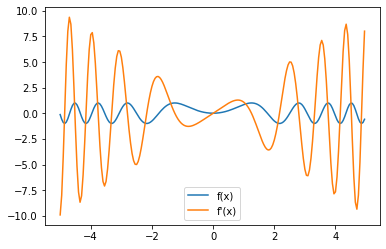

In [276]:
def test_numerical_gradient():
    func = lambda x: np.sin(x ** 2)

    x = np.arange(-5, 5, 0.05)
    y = np.array([func(x) for x in x.tolist()])

    dx = np.array([numerical_gradient(func, np.array([x])) for x in x.tolist()])

    plt.plot(x, y, label='f(x)')
    plt.plot(x, dx.flatten(), label='f\'(x)')
    
    plt.legend()

test_numerical_gradient()

## Mean Square Error Loss Function
---

Let's start off by implementing the MSE loss class. The purpose of this is to be able to compute the loss w.r.t. some target values. MSE loss is defined as

$$
c = \frac{1}{n} \sum_{i = 1}^{n} (y_i - \hat{y_i})^2 
$$

and therefore the gradient w.r.t. $y$ is

$$
\frac{\partial c}{\partial y} = \frac{2}{n} \sum_{i = 1}^{n} (y_i - \hat{y_i})
$$

In [277]:
class MSELoss:
    def forward(self, y, target):
        """
        Computes the loss of each entry in the batch.

        Args:
            y      : The actual output from the neural network. Shape of (batch_size, out_features).
            target : The real target. Shape of (batch_size, out_features).
        
        Returns:
            c : The loss of each entry in the batch. Shape of (batch_size, 1).
        """

        # Note: Keep the differences for the gradient computation
        self.diff = y - target

        return np.sum(np.square(self.diff)) / self.diff.size

    def backward(self):
        """
        Computes the gradient of the loss w.r.t. `y`.
        
        Returns:
            dy : The gradient of the loss w.r.t. `y`. Shape of (batch_size, out_features).
        """

        return 2 / self.diff.size * self.diff

In [278]:
def test_MSELoss_backward():
    batch_size, out_features = 2, 3
    
    y = np.random.randn(batch_size, out_features)
    target = np.zeros((batch_size, out_features))

    loss = MSELoss()

    loss.forward(y, target)
    dy = loss.backward()

    dy_num = numerical_gradient(
        lambda y: loss.forward(y.reshape((batch_size, out_features)), target),
        y.flatten()
    )[0].reshape((batch_size, out_features))

    print('Analytical gradient:\n', dy, '\n\n', 'Numerical gradient:\n', dy_num)
    assert np.allclose(dy, dy_num), 'Analytical and numerical results differ'

test_MSELoss_backward()

Analytical gradient:
 [[-0.57981516 -0.1389722   0.6296589 ]
 [ 0.20864166  0.29395369 -0.41941705]] 

 Numerical gradient:
 [[-0.57981516 -0.1389722   0.6296589 ]
 [ 0.20864166  0.29395369 -0.41941705]]


## Activation functions
---

The next component we need, is the activation function. There are multiple options to choose from but we will implement two, ReLU and Tanh.

ReLU is defined as

$$
y = \text{max}(0, z)
$$

and its gradient is

$$
\frac{\partial y}{\partial z} =
    \begin{cases}
      0 &\text{if } z < 0 \\
      1 &\text{if } z > 0
    \end{cases}
$$

Additionally, Tanh is defined as

$$
y = \text{tanh}(z)
$$

and its gradient is

$$
\frac{\partial y}{\partial z} = 1 - \text{tanh}(x)^{2}
$$

In [279]:
class ReLU:
    def forward(self, x):
        """
        Args:
            x : Output from the previous layer. Shape of (batch_size, features).

        Returns:
            y : Input after the activation function. Shape of (batch_size, features).
        """

        # Note: Keep for gradients
        self.x = x

        return np.maximum(x, np.zeros(x.shape))

    def backward(self, dy):
        """
        Args:
            dy : Gradient of the loss w.r.t. `y`. Shape of (batch_size, features).

        Returns:
            dx : Gradient of the loss w.r.t. `x`. Shape of (batch_size, features).
        """

        return np.where(self.x > 0, np.ones(self.x.shape), np.zeros(self.x.shape)) * dy

In [280]:
class Tanh:
    def forward(self, x):
        """
        Args:
          x (array): Input of shape (batch_size, xsize).
        
        Returns:
          y (array): Output of shape (batch_size, xsize).
        """
        
        # Note: Keep for gradients
        self.x = x

        return np.tanh(x)

    def backward(self, dy):
        """
        Args:
            dy : Gradient of the loss w.r.t. `y`. Shape of (batch_size, features).

        Returns:
            dx : Gradient of the loss w.r.t. `x`. Shape of (batch_size, features).
        """

        return (1 - np.tanh(self.x) ** 2) * dy

In [281]:
def test_activation_backward():
    # The network is x --> activation --> MSELoss

    x = np.random.randn(2, 3)
    target = np.zeros((2, 3))
    
    act_fns = [['ReLU', ReLU() ], ['Tang', Tanh()]]
    
    for act_fn in act_fns:
        name, act_fn = act_fn[0], act_fn[1]
        
        loss = MSELoss()
        loss.forward(act_fn.forward(x), target)
        
        dx = act_fn.backward(loss.backward())
        
        dx_num = numerical_gradient(
            lambda x: loss.forward(act_fn.forward(x.reshape((2, 3))), target),
            x.flatten()
        )[0].reshape((2, 3))
        
        print('Analytical gradient:\n', dx, '\n\n', 'Numerical gradient:\n', dx_num, '\n')
        assert np.allclose(dx, dx_num), 'Analytical and numerical results differ'
        print(name, "success!\n")

test_activation_backward()

Analytical gradient:
 [[0.73393764 0.         0.        ]
 [0.         0.         0.        ]] 

 Numerical gradient:
 [[0.73393764 0.         0.        ]
 [0.         0.         0.        ]] 

ReLU success!

Analytical gradient:
 [[ 0.01553394 -0.12708833 -0.02852792]
 [-0.0454792  -0.06451782 -0.09735211]] 

 Numerical gradient:
 [[ 0.01553394 -0.12708833 -0.02852792]
 [-0.0454792  -0.06451782 -0.09735211]] 

Tang success!



## Linear Layer
---

Next, probably the most interesting component, the linear layer.

In [282]:
class Linear:
    def __init__(self, in_features, out_features):
        bound = np.sqrt(6) / np.sqrt(in_features + out_features)

        self.W = np.random.uniform(-bound, bound, (out_features, in_features))
        self.b = np.zeros((out_features))

        self.x = None

        self.dW = None
        self.db = None

    def forward(self, x, W = None, b = None):
        """
        Args:
            x : Inputs of shape (batch_size, in_features).
            W : Optional weights of shape (out_features, in_features).
            b : Optional bias terms of shape (out_features).

        Returns:
            y : Outputs of shape (batch_size, out_features).
        """

        _W = self.W if W is None else W
        _b = self.b if b is None else b

        self.x = x

        return x @ _W.T + _b.T

    def backward(self, dy):
        """
        Args:
            dy : Gradient of the loss w.r.t. `y`. Shape of (batch_size, out_features)

        Returns:
            dx : Gradient of the loss w.r.t. `x`. Shape of (batch_size, in_features)
        """
        
        self.dW = dy.T @ self.x
        self.db = np.sum(dy.T, axis=1)

        return dy @ self.W

In [283]:
def test_Linear_backward():
    batch_size, in_features, out_features = 3, 5, 3

    # Define the network
    loss_fn = MSELoss()
    act_fn = ReLU()
    linear = Linear(in_features, out_features)

    x = np.random.randn(batch_size, in_features)
    target = np.zeros((batch_size, out_features))
    
    W = linear.W.copy()
    b = linear.b.copy()
    
    # Do the forward pass
    c = loss_fn.forward(act_fn.forward(linear.forward(x)), target)
    
    # Do the backward pass
    dx = linear.backward(act_fn.backward(loss_fn.backward()))
    
    # Compute the numerical gradients

    # dx
    dx_num = numerical_gradient(
        lambda x: loss_fn.forward(
            act_fn.forward(
                linear.forward(x.reshape((batch_size, in_features)))
            ),
            target
        ),
        x.flatten()
    )
    
    dx_num = dx_num[0].reshape((batch_size, in_features))
    
    print('Analytical dx:\n', dx, '\n\n', 'Numerical dx:\n', dx_num, '\n')    
    assert np.allclose(dx, dx_num), 'Analytical and numerical dx differ'
    
    # dW
    dW_num = numerical_gradient(
        lambda W: loss_fn.forward(
            act_fn.forward(
                linear.forward(x, W.reshape((out_features, in_features)), b)
            ),
            target
        ),
        W.flatten()
    )
    
    dW_num = dW_num[0].reshape((out_features, in_features))
    
    print('Analytical dW:\n', linear.dW, '\n\n', 'Numerical dW:\n', dW_num, '\n')
    assert np.allclose(linear.dW, dW_num), 'Analytical and numerical dW differ'
    
    # db
    db_num = numerical_gradient(
        lambda b: loss_fn.forward(
            act_fn.forward(
                linear.forward(x, W, b)
            ),
            target
        ),
        b
    )[0]

    print('Analytical db:\n', linear.db, '\n\n', 'Numerical db:\n', db_num, '\n')
    assert np.allclose(linear.db, db_num), 'Analytical and numerical db differ'

    print('Success')

test_Linear_backward()

Analytical dx:
 [[ 0.          0.          0.          0.          0.        ]
 [-0.05689162 -0.27895316 -0.11646609  0.01038603  0.1825011 ]
 [-0.03629098 -0.15253426 -0.02768285 -0.00915719  0.10331634]] 

 Numerical dx:
 [[ 0.          0.          0.          0.          0.        ]
 [-0.05689162 -0.27895316 -0.11646609  0.01038603  0.1825011 ]
 [-0.03629098 -0.15253426 -0.02768285 -0.00915719  0.10331634]] 

Analytical dW:
 [[-0.28015736 -0.4326525  -0.48260479 -0.1753335   0.64513619]
 [-0.32918576 -0.46041138 -0.53043958 -0.10360848  0.59887817]
 [ 0.          0.          0.          0.          0.        ]] 

 Numerical dW:
 [[-0.28015736 -0.4326525  -0.48260479 -0.1753335   0.64513619]
 [-0.32918576 -0.46041138 -0.53043958 -0.10360848  0.59887817]
 [ 0.          0.          0.          0.          0.        ]] 

Analytical db:
 [0.4721027  0.43996082 0.        ] 

 Numerical db:
 [0.4721027  0.43996082 0.        ] 

Success


## Constructing the Neural Network
---

In [284]:
class MLP:
    def __init__(self, in_features, hidden_sizes, out_features, activation_fn = Tanh):
        self.modules = [
            Linear(in_features, hidden_sizes[0]),
            activation_fn()
        ]
        
        for i in range(len(hidden_sizes) - 1):
            self.modules.append(Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            self.modules.append(activation_fn())

        self.modules.append(Linear(hidden_sizes[-1], out_features))

    def forward(self, x):
        y = x
        
        for layer in self.modules:
            y = layer.forward(y)
        
        return y

    def backward(self, dy):
        dx = dy
        
        for i in range(len(self.modules) - 1, -1, -1):
            dx = self.modules[i].backward(dx)

        return dx

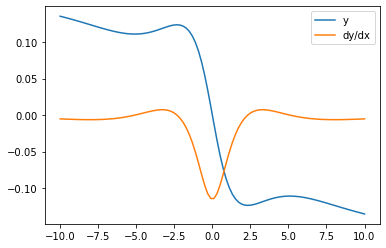

In [285]:
def test_mlp():
    batch_size = 100
    
    mlp = MLP(1, [10, 20], 1)

    x = np.linspace(-10, 10, batch_size)
    y = mlp.forward(x.reshape((batch_size, 1))).flatten()

    dx = mlp.backward(np.ones((batch_size, 1))).flatten()

    # Plot the output and its gradient
    plt.plot(x, y, label='y')
    plt.plot(x, dx, label='dy/dx')

    plt.legend()

test_mlp()

## Training for a Toy Dataset
---

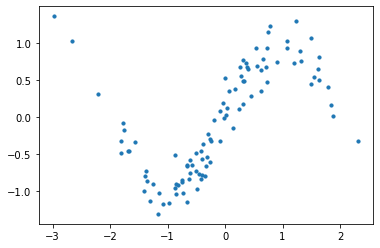

In [122]:
def generate_toy_data(plot = False):
    x = np.sort(np.random.randn(100, 1), axis=0)

    targets = np.sin(x * np.pi / 2)
    targets = targets + 0.25 * np.random.randn(x.shape[0], x.shape[1])

    if plot:
        plt.scatter(x, targets, s=10)

    return x, targets

toy_x, toy_targets = generate_toy_data(True);

In [123]:
def train_toy_neural_network_with_animation(activation_fn = Tanh):
    # Generate the toy dataset
    x, targets = generate_toy_data()
    
    # Initialise static stuff
    epochs = 750
    loss = MSELoss()

    # Initialise dynamic stuff
    net = None
    learning_rate = None
    
    def init():
        nonlocal net, learning_rate

        net = MLP(1, [20, 20, 10], 1, activation_fn=activation_fn)
        learning_rate = 0.075
        
    # Initialise the figure
    fig, ax = plt.subplots(1)
    
    ax.scatter(x, targets, s=10)
    net_line, = ax.plot([], [], 'r-')

    # Animate a single frame (do 10 epochs for every frame!)
    def animate(i):
        nonlocal x, targets, net, learning_rate

        y = None

        for i in range(10):
            # Forward pass
            y = net.forward(x)
            c = loss.forward(y, targets)

            # Backward pass
            dy = loss.backward()
            dx = net.backward(dy)

            # Gradient descent update
            learning_rate *= 0.998

            for module in net.modules:
                if hasattr(module, 'W'):
                    module.W = module.W - module.dW * learning_rate
                    module.b = module.b - module.db * learning_rate

        # Update the plot
        net_line.set_data(x, y)
        
    # Return the trained net and the animation
    return net, animation.FuncAnimation(
        fig,
        animate,
        init_func=init,
        frames=int(epochs / 10),
        interval=60
    )

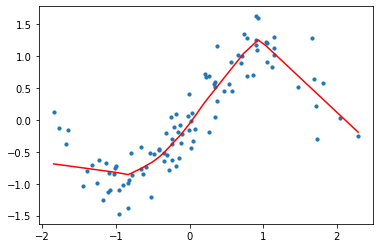

In [124]:
toy_net_ReLU, toy_net_ReLU_animation = train_toy_neural_network_with_animation(ReLU)
toy_net_ReLU_animation

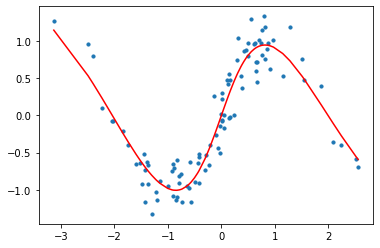

In [125]:
toy_net_Tanh, toy_net_Tanh_animation = train_toy_neural_network_with_animation(Tanh)
toy_net_Tanh_animation

## Training for MNIST
---

Let's start off with loading the dataset in memory.

In [316]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(np.int)

Let's plot 9 of the first images in the dataset just to get an idea of what we are dealing with.

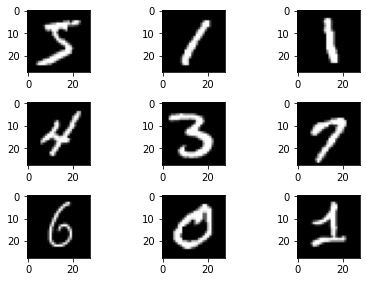

In [317]:
fig, axs = plt.subplots(3, 3)

for i, axi in enumerate(axs.flat):
    img = X[i * o, :].reshape((28, 28)) / 255
    axi.imshow(img, cmap="gray")

plt.tight_layout(True)
plt.show()

Our task is now to somehow be able to teach our neural network to be able to classify the hand-written digits. For these types of one-hot classification tasks MSE loss is not the ideal one but cross-entropy is widely used for classification.

In [340]:
def softmax(x):
    """
    Applies the Softmax activation function to `x`.

    Args:
        x : Inputs of shape (batch_size, n_classes).

    Returns:
        z : Inputs after the Softmax function is applied. Shape of (batch_size, n_classes).
    """

    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)), axis=1).reshape((-1, 1))

class CrossEntropyWithSoftmax:
    def forward(self, x, target):
        self.grad = x - target
        self.x = x
        self.target = target
        return -1 * np.sum(target * np.log(softmax(x)))

    def backward(self):
        return self.grad

In [341]:
def test_CrossEntropy_backward():
    batch_size, out_features = 2, 3

    # Generate the output from softmax
    y = np.random.uniform(0, 1, (batch_size, out_features))
    y = y / np.sum(y, axis=1).reshape((-1, 1))

    # Generate the targets
    indices = np.random.randint(0, out_features, (batch_size, 1))

    target = np.zeros((batch_size, out_features))
    target[np.arange(batch_size), indices[:, 0]] = 1

    # Do the loss computations
    loss = CrossEntropy()

    loss.forward(y, target)
    dy = loss.backward()

    dy_num = numerical_gradient(
        lambda y: loss.forward(y.reshape((batch_size, out_features)), target),
        y.flatten()
    )[0].reshape((batch_size, out_features))

    print('Analytical gradient:\n', dy, '\n\n', 'Numerical gradient:\n', dy_num)
    assert np.allclose(dy, dy_num), 'Analytical and numerical results differ'

test_CrossEntropy_backward()

Analytical gradient:
 [[-0.         -2.33809132 -0.        ]
 [-0.         -7.37319947 -0.        ]] 

 Numerical gradient:
 [[ 0.         -2.33809136  0.        ]
 [ 0.         -7.3732008   0.        ]]


Next, let's split our data into training and testing sets.

In [350]:
from sklearn.model_selection import train_test_split

n_train = 60000
n_test = 10000

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=n_train,
    test_size=n_test
)

In [354]:
def train_mnist_neural_network(net, epoch_count = 50, initial_learning_rate = 0.001):
    loss = CrossEntropyWithSoftmax()

    batch_size = 50
    learning_rate = initial_learning_rate

    # Train over epochs
    for i in range(1, epoch_count + 1):
        print(f"Starting epoch {i}...")

        # Loop through batches
        epoch_loss = 0

        for batch_i in range(int(n_train / batch_size)):
            # Pick the batch from the training set
            batch_indices = np.arange(
                batch_i * batch_size,
                batch_i * batch_size + batch_size
            )

            X_batch = X_train[batch_indices, :] / 255

            y_batch = np.zeros((batch_size, 10))
            y_batch[np.arange(batch_size), y_train[batch_indices].astype(np.int)] = 1

            # Forward pass
            y = net.forward(X_batch)
            c = loss.forward(y, y_batch)

            epoch_loss += c

            # Backward pass
            dy = loss.backward()
            dx = net.backward(dy)

            # Gradient descent update
            # learning_rate *= 0.995

            for module in net.modules:
                if hasattr(module, 'W'):
                    module.W = module.W - module.dW * learning_rate
                    module.b = module.b - module.db * learning_rate
        
        print(f"Loss for epoch {i} was {epoch_loss}...")

        # Compute the accuracy on the test set
        y = net.forward(X_test / 255)

        predicted_class = np.argmax(y, axis=1)

        n_correct = np.sum(predicted_class == y_test)
        accuracy = n_correct / n_test

        print(f"Accuracy for epoch {i} was {accuracy * 100}%...")

In [365]:
net = MLP(784, [512, 32], 10, activation_fn=ReLU)

In [369]:
train_mnist_neural_network(net, 10, 0.0075)

Starting epoch 1...
Loss for epoch 1 was 88491.78024587398...
Accuracy for epoch 1 was 98.16%...
Starting epoch 2...
Loss for epoch 2 was 88413.89823842187...
Accuracy for epoch 2 was 98.1%...
Starting epoch 3...
Loss for epoch 3 was 88362.50381685304...
Accuracy for epoch 3 was 98.21%...
Starting epoch 4...
Loss for epoch 4 was 88315.580905968...
Accuracy for epoch 4 was 98.17%...
Starting epoch 5...
Loss for epoch 5 was 88275.17595336305...
Accuracy for epoch 5 was 98.16%...
Starting epoch 6...
Loss for epoch 6 was 88239.16056257472...
Accuracy for epoch 6 was 98.17%...
Starting epoch 7...
Loss for epoch 7 was 88209.71598545727...
Accuracy for epoch 7 was 98.15%...
Starting epoch 8...
Loss for epoch 8 was 88180.33189214054...
Accuracy for epoch 8 was 98.1%...
Starting epoch 9...
Loss for epoch 9 was 88156.66142069043...
Accuracy for epoch 9 was 98.17%...
Starting epoch 10...
Loss for epoch 10 was 88132.59055768477...
Accuracy for epoch 10 was 98.16%...
